In [1]:
import pickle
import bcolz
import numpy as np
import pandas as pd
from tqdm import tqdm


In [2]:
words = []
idx = 0
glove_path = './glove/'
word2idx = {}

In [3]:
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.300d.dat', mode='w')
with open(f'{glove_path}/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 300)), rootdir=f'{glove_path}/6B.300d.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.300d_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.300d_idx.pkl', 'wb'))

In [4]:
vectors = bcolz.open(f'{glove_path}/6B.300d.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.300d_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.300d_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [93]:
np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

0.7165080993153707

In [3]:
corpus = pd.read_csv('./dataset/kit_mocap_dataset/desc_final.csv')

In [1]:
import operator
import spacy

nlp = spacy.load('en_core_web_sm')
def process_text(sentence):
    sentence = sentence.replace('-', '')
    doc = nlp(sentence)
    word_list = []
    pos_list = []
    for token in doc:
        word = token.text
        if not word.isalpha():
            continue
        if (token.pos_ == 'NOUN' or token.pos_ == 'VERB') and (word != 'left'):
            word_list.append(token.lemma_)
        else:
            word_list.append(word)
        pos_list.append(token.pos_)
    return word_list, pos_list
            

black_list = ',.’\'°⁰;\")('

def build_vocab(sentences, verbose=True):
    vocab = {}
    for sentence in tqdm(sentences, disable= (not verbose)):
        words, _ = process_text(sentence.lower())
        for word in words:
            word = ''.join( w for w in word if w not in black_list)
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab, embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except KeyError:
            oov[word] = vocab[word]
            i += vocab[word]
            pass
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x, a

In [2]:
doc = nlp("A person is doing jumping jacks, then start jogging in place.")

In [5]:
[token.text + '/' + token.pos_ for token in doc]

['A/DET',
 'person/NOUN',
 'is/AUX',
 'doing/VERB',
 'jumping/VERB',
 'jacks/NOUN',
 ',/PUNCT',
 'then/ADV',
 'start/VERB',
 'jogging/VERB',
 'in/ADP',
 'place/NOUN',
 './PUNCT']

In [5]:
vocab = build_vocab(list(corpus['desc']))

100%|██████████| 12700/12700 [00:58<00:00, 215.29it/s]


In [6]:
from os.path import join as pjoin
words = pickle.load(open(pjoin('./glove', '%s_words.pkl'%'our_vab'), 'rb'))
word2idx = pickle.load(open(pjoin('./glove', '%s_idx.pkl'%'our_vab'), 'rb'))

In [7]:
oov, cov = check_coverage(vocab, word2idx)

100%|██████████| 1287/1287 [00:00<00:00, 1670711.62it/s]

Found embeddings for 76.15% of vocab
Found embeddings for  98.84% of all text


In [27]:
oov, cov = check_coverage(vocab, glove)

100%|██████████| 5371/5371 [00:00<00:00, 554280.12it/s]

Found embeddings for 78.12% of vocab
Found embeddings for  99.53% of all text


In [18]:
sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1))[::-1]


In [19]:
len(vocab)

1287

In [20]:
sorted_vocab[:100]

[('a', 14470),
 ('person', 8622),
 ('walk', 6294),
 ('the', 4516),
 ('forward', 3149),
 ('and', 3042),
 ('to', 2676),
 ('step', 2574),
 ('is', 2512),
 ('human', 2284),
 ('left', 2178),
 ('right', 2178),
 ('with', 1746),
 ('in', 1524),
 ('turn', 1516),
 ('his', 1272),
 ('circle', 1234),
 ('hand', 1130),
 ('someone', 1094),
 ('on', 1074),
 ('then', 926),
 ('push', 852),
 ('back', 778),
 ('perform', 778),
 ('forwards', 745),
 ('backwards', 614),
 ('foot', 594),
 ('from', 584),
 ('slowly', 556),
 ('take', 544),
 ('run', 538),
 ('around', 534),
 ('get', 530),
 ('go', 526),
 ('down', 526),
 ('jump', 502),
 ('up', 496),
 ('its', 494),
 ('arm', 486),
 ('of', 486),
 ('few', 484),
 ('while', 468),
 ('something', 468),
 ('start', 450),
 ('degree', 448),
 ('stand', 448),
 ('make', 436),
 ('quarter', 434),
 ('two', 382),
 ('play', 374),
 ('again', 366),
 ('move', 358),
 ('side', 344),
 ('front', 318),
 ('clockwise', 297),
 ('one', 294),
 ('both', 288),
 ('counterclockwise', 278),
 ('an', 268),
 ('s

In [17]:
len(sorted_vocab)

5371

In [28]:
len(cov)

4196

In [75]:
len(oov)

1591

In [50]:
word_embeds = []
words = []
word2idx = {}

words.append('sos')
word2idx['sos'] = 0
word_embeds.append(np.random.normal(size=(1, 300)))

words.append('eos')
word2idx['eos'] = 1
word_embeds.append(np.random.normal(size=(1, 300)))

words.append('unk')
word2idx['unk'] = 2
word_embeds.append(np.random.normal(size=(1, 300)))

idx = 3
for word, embedding in cov.items():
    words.append(word)
    word2idx[word] = idx
    word_embeds.append(embedding.reshape(1, -1))
    idx += 1

words_embeds = np.concatenate(word_embeds, axis=0)


In [51]:
np.save('%s/our_vab_data.npy'%(glove_path), words_embeds)
pickle.dump(words, open(f'{glove_path}/our_vab_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/our_vab_idx.pkl', 'wb'))

In [42]:
words_embeds.shape

(4198, 300)

In [43]:
len(words)

4198

In [8]:
words_embeds[word2idx['unk']]

NameError: name 'words_embeds' is not defined

## Our Dataset

In [59]:
import codecs as cs
from os.path import join as pjoin
text_save_path = './dataset/pose_data_raw/texts'
desc_all = corpus
for i in tqdm(range(len(desc_all))):
    caption = desc_all.iloc[i]['caption']
    start = desc_all.iloc[i]['from']
    end = desc_all.iloc[i]['to']
    name = desc_all.iloc[i]['new_joint_name']
    word_list, pose_list = process_text(caption)
    tokens = ' '.join(['%s/%s'%(word_list[i], pose_list[i]) for i in range(len(word_list))])
    with cs.open(pjoin(text_save_path, name.replace('npy', 'txt')), 'a+') as f:
        f.write('%s#%s#%s#%s\n'%(caption, tokens, start, end))

100%|██████████| 87384/87384 [07:25<00:00, 196.19it/s]


## KIT Dataset

In [9]:
import codecs as cs
from os.path import join as pjoin
text_save_path = './dataset/kit_mocap_dataset/texts'
desc_all = corpus
for i in tqdm(range(len(desc_all))):
    caption = desc_all.iloc[i]['desc']
    start = 0.0
    end = 0.0
    name = desc_all.iloc[i]['data_id']
    word_list, pose_list = process_text(caption)
    tokens = ' '.join(['%s/%s'%(word_list[i], pose_list[i]) for i in range(len(word_list))])
    with cs.open(pjoin(text_save_path, name + '.txt'), 'a+') as f:
        f.write('%s#%s#%s#%s\n'%(caption, tokens, start, end))

100%|██████████| 12700/12700 [01:03<00:00, 199.95it/s]


In [10]:
desc_all['length'] = desc_all['desc'].apply(lambda x: len(x.split(' ')))

In [11]:
desc_all['length'].describe()

count    12700.000000
mean         8.428661
std          4.338776
min          3.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         39.000000
Name: length, dtype: float64

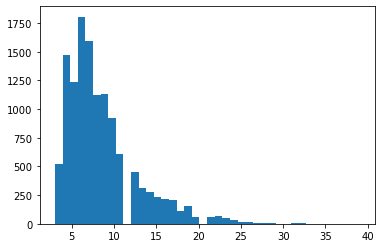

In [15]:
import matplotlib.pyplot as plt
plt.hist(desc_all['length'], bins=40)
plt.show()

In [74]:
np.random.rand(1)

array([0.65991835])

In [1]:
from utils.word_vectorizer import WordVectorizer

In [2]:
w_vectorizer = WordVectorizer('./glove/')

In [9]:
word_vec, pos_vec = w_vectorizer['unk/OTHER']

In [10]:
pos_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [11]:
word_vec.shape

(300,)

In [7]:
len(w_vectorizer)

4199

In [4]:
corpus['from'].describe()

count    87192.000000
mean         0.018281
std          0.262955
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: from, dtype: float64

In [5]:
corpus.loc[corpus['new_joint_name']=='009551.npy']

,animation_path,caption,from,to,raw_joint_path,new_joint_name,is_mirror
28555,./animations/CMU/63/63_14_poses_0_94.mp4,a person stands slightly bent over with both i...,0.0,0.0,./pose_data/CMU/63/63_14_poses_0_94.npy,009551.npy,False
28556,./animations/CMU/63/63_14_poses_0_94.mp4,person lightly taps a golf ball with his golf ...,0.0,0.0,./pose_data/CMU/63/63_14_poses_0_94.npy,009551.npy,False
28557,./animations/CMU/63/63_14_poses_0_94.mp4,a person grabs his wrist and practices a putt.,NaN,NaN,./pose_data/CMU/63/63_14_poses_0_94.npy,009551.npy,False


In [10]:
corpus['to'].isnull().sum()

56

In [ ]:
p = ['a', 'b', 'c']